In [3]:
import warnings
warnings.filterwarnings(action="ignore", category=DeprecationWarning)
warnings.filterwarnings(action="ignore", category=FutureWarning)
import pandas as pd
import lightkurve as lk
import numpy as np
import pywt
import pickle
import time
import os
import matplotlib.pyplot as plt
from context import LCWavelet
from context import binning
from parallelbar import progress_map
from tqdm import tqdm
from functools import partial
import logging
# import gc

In [4]:
path = r'E:\Diego\Astrofisica\TFM\ExoPlanet-Detection\data3\mastDownload\Kepler'
files = os.listdir(path)
files = [f for f in files]
ds = pd.read_csv(r'E:\Diego\Astrofisica\TFM\ExoPlanet-Detection\cumulative_2022.09.30_09.06.43.csv', skiprows=144)
print('Number of files:', len(files))
ds

Number of files: 9513


,rowid,kepid,kepoi_name,kepler_name,koi_disposition,koi_vet_stat,koi_vet_date,koi_pdisposition,koi_score,koi_fpflag_nt,...,koi_dicco_mdec,koi_dicco_mdec_err,koi_dicco_msky,koi_dicco_msky_err,koi_dikco_mra,koi_dikco_mra_err,koi_dikco_mdec,koi_dikco_mdec_err,koi_dikco_msky,koi_dikco_msky_err
0,1,10797460,K00752.01,Kepler-227 b,CONFIRMED,Done,2018-08-16,CANDIDATE,1.000,0,...,0.200,0.160,0.200,0.170,0.080,0.130,0.310,0.170,0.320,0.160
1,2,10797460,K00752.02,Kepler-227 c,CONFIRMED,Done,2018-08-16,CANDIDATE,0.969,0,...,0.000,0.480,0.390,0.360,0.490,0.340,0.120,0.730,0.500,0.450
2,3,10811496,K00753.01,NaN,CANDIDATE,Done,2018-08-16,CANDIDATE,0.000,0,...,-0.034,0.070,0.042,0.072,0.002,0.071,-0.027,0.074,0.027,0.074
3,4,10848459,K00754.01,NaN,FALSE POSITIVE,Done,2018-08-16,FALSE POSITIVE,0.000,0,...,0.147,0.078,0.289,0.079,-0.257,0.072,0.099,0.077,0.276,0.076
4,5,10854555,K00755.01,Kepler-664 b,CONFIRMED,Done,2018-08-16,CANDIDATE,1.000,0,...,-0.090,0.180,0.100,0.140,0.070,0.180,0.020,0.160,0.070,0.200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9559,9560,10090151,K07985.01,NaN,FALSE POSITIVE,Done,2018-08-16,FALSE POSITIVE,0.000,0,...,-1.757,0.068,2.763,0.074,2.344,0.072,-1.756,0.068,2.929,0.072
9560,9561,10128825,K07986.01,NaN,CANDIDATE,Done,2018-08-16,CANDIDATE,0.497,0,...,-0.250,0.490,0.780,0.460,0.500,0.400,-0.180,0.470,0.530,0.470
9561,9562,10147276,K07987.01,NaN,FALSE POSITIVE,Done,2018-08-16,FALSE POSITIVE,0.021,0,...,-3.650,0.260,5.000,0.220,3.380,0.160,-3.890,0.260,5.160,0.220
9562,9563,10155286,K07988.01,NaN,CANDIDATE,Done,2018-08-16,CANDIDATE,0.092,0,...,1.320,0.670,1.690,0.530,1.450,0.110,1.370,0.660,2.000,0.460


In [5]:
count = 0
print(files)
for i, row in ds.iterrows():
    kepid = row['kepid']
    kepid = str(kepid).zfill(9)
    print('kepid:', kepid)
    dir_id = [f for f in files if kepid in f]
    print('dir_id:', dir_id)
    break

print('Number of files in the list:', count)
print('Number of files in the list:', len(files))



['kplr010797460_lc_Q011111111111111111', 'kplr009334289_lc_Q011111111111111111', 'kplr003247268_lc_Q011111011101110111', 'kplr008972058_sc_Q000333310000000000', 'kplr004918309_lc_Q011111111111111111', 'kplr009662811_lc_Q111111101110111011', 'kplr007449554_lc_Q001111111111111111', 'kplr009757613_lc_Q011111111111111111', 'kplr009757613_sc_Q000000333333333332', 'kplr008972058_lc_Q111111111111111111', 'kplr003247268_sc_Q000000000303010311', 'kplr009334289_sc_Q000000000330300032', 'kplr004918309_sc_Q000000000000010300', 'kplr011570749_lc_Q011111111111111111', 'kplr009351920_lc_Q011111111111111111', 'kplr010811496_lc_Q011111101110111011', 'kplr012602568_lc_Q011111111111111111', 'kplr011570749_sc_Q000000000000000301', 'kplr004386059_lc_Q001111011101110111', 'kplr003232859_lc_Q011111111111111111', 'kplr010848459_lc_Q011111110111011101', 'kplr002161536_lc_Q011111111111111111', 'kplr011297236_lc_Q011111111111111111', 'kplr009347899_lc_Q011111111111111111', 'kplr009941066_lc_Q011111111111111111',

In [6]:
first = files[0]
print('First file:', first)
kepler_files = [f for f in os.listdir(os.path.join(path, first)) if f.endswith('.fits')]
lcs = [lk.read(os.path.join(path, first, f)) for f in kepler_files]
lc_coll = lk.LightCurveCollection(lcs)
lc_ro = lc_coll.stitch()
lc_nonans = lc_ro.remove_nans()

First file: kplr010797460_lc_Q011111111111111111


In [7]:
row = ds[ds['kepid'] == 10797460].iloc[0]
row

rowid                            1
kepid                     10797460
kepoi_name               K00752.01
kepler_name           Kepler-227 b
koi_disposition          CONFIRMED
                          ...     
koi_dikco_mra_err             0.13
koi_dikco_mdec                0.31
koi_dikco_mdec_err            0.17
koi_dikco_msky                0.32
koi_dikco_msky_err            0.16
Name: 0, Length: 141, dtype: object

<AxesSubplot:xlabel='Phase [JD]', ylabel='Normalized Flux'>

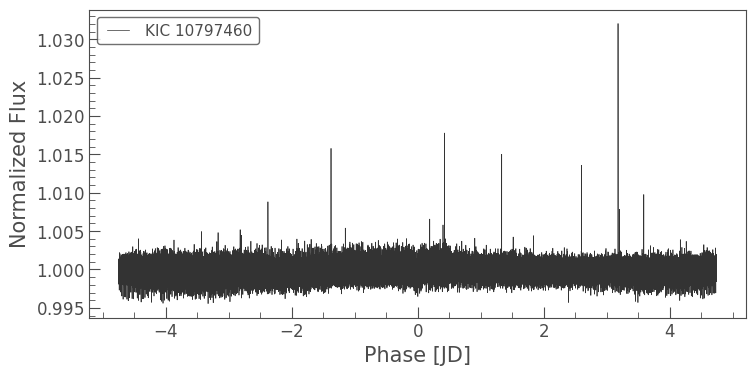

In [8]:
lc_fold = lc_nonans.fold(period=row.koi_period, epoch_time=row.koi_time0bk)
lc_fold.plot()

In [18]:
lc_odd = lc_fold[lc_fold.odd_mask]
lc_even = lc_fold[lc_fold.even_mask]

lc_odd.sort('time')
lc_even.sort('time')

lc_odd_global = binning.global_view(lc_odd.time.to_value('jd'), lc_odd.flux.to_value(), row.koi_period, normalize=True)
lc_even_global = binning.global_view(lc_even.time.to_value('jd'), lc_even.flux.to_value(), row.koi_period, normalize=True)
lc_odd_global = lk.lightcurve.FoldedLightCurve(time=np.arange(len(lc_odd_global)), flux=lc_odd_global)
lc_even_global = lk.lightcurve.FoldedLightCurve(time=np.arange(len(lc_even_global)), flux=lc_even_global)

lc_odd_local = binning.local_view(lc_odd.time.to_value('jd'), lc_odd.flux.to_value(), row.koi_period, row.koi_duration, normalize=True)
lc_even_local = binning.local_view(lc_even.time.to_value('jd'), lc_even.flux.to_value(), row.koi_period, row.koi_duration, normalize=True)
lc_odd_local = lk.lightcurve.FoldedLightCurve(time=np.arange(len(lc_odd_local)), flux=lc_odd_local)
lc_even_local = lk.lightcurve.FoldedLightCurve(time=np.arange(len(lc_even_local)), flux=lc_even_local)


In [19]:
levels=[1, 2, 3, 4]
wavelet_family="sym5"
cut_border_percent=0.1
wavelet_window = None
headers = {
        "period": row.koi_period,
        "koi_period_err1": row.koi_period_err1,
        "koi_period_err2": row.koi_period_err2,
        "depth": row.koi_depth,
        "depth_err1": row.koi_depth_err1,
        "depth_err2": row.koi_depth_err2,
        "duration": row.koi_duration,
        "duration_err1": row.koi_duration_err1,
        "duration_err2": row.koi_duration_err2,
        "steff": row.koi_steff,
        "steff_err1": row.koi_steff_err1,
        "steff_err2": row.koi_steff_err2,
        "impact": row.koi_impact,
        "impact_err1": row.koi_impact_err1,
        "impact_err2": row.koi_impact_err2,
        "class": row.koi_disposition,
        "wavelet_family":wavelet_family,
        "levels":levels,
        "window":wavelet_window,
        "border_cut":cut_border_percent,
        "Kepler_name":row.kepoi_name
    }
    

In [ ]:
wavelet_window = 9
lc_odd_global = LCWavelet.cut_wavelet(lc_odd_global, wavelet_window)
lc_even_global = LCWavelet.cut_wavelet(lc_even_global, wavelet_window)
lc_odd_local = LCWavelet.cut_wavelet(lc_odd_local, wavelet_window)
lc_even_local = LCWavelet.cut_wavelet(lc_even_local, wavelet_window)

TypeError: bad operand type for abs(): 'Time'

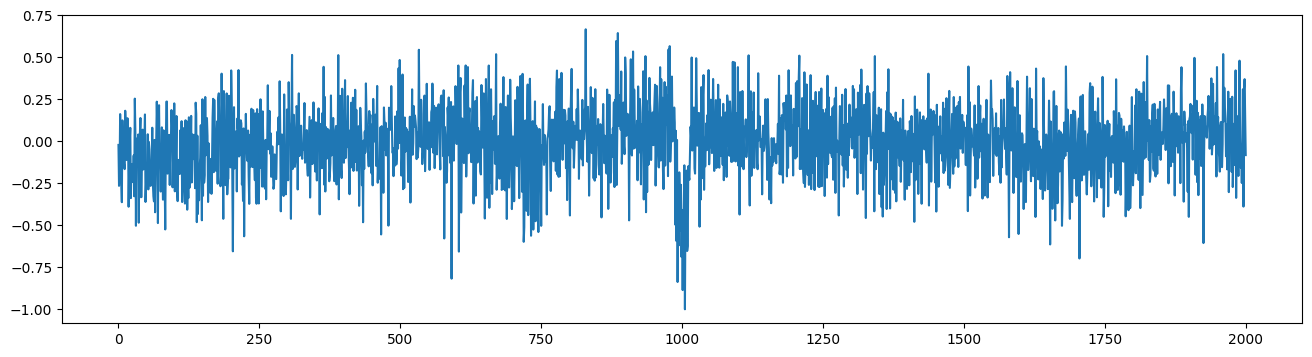

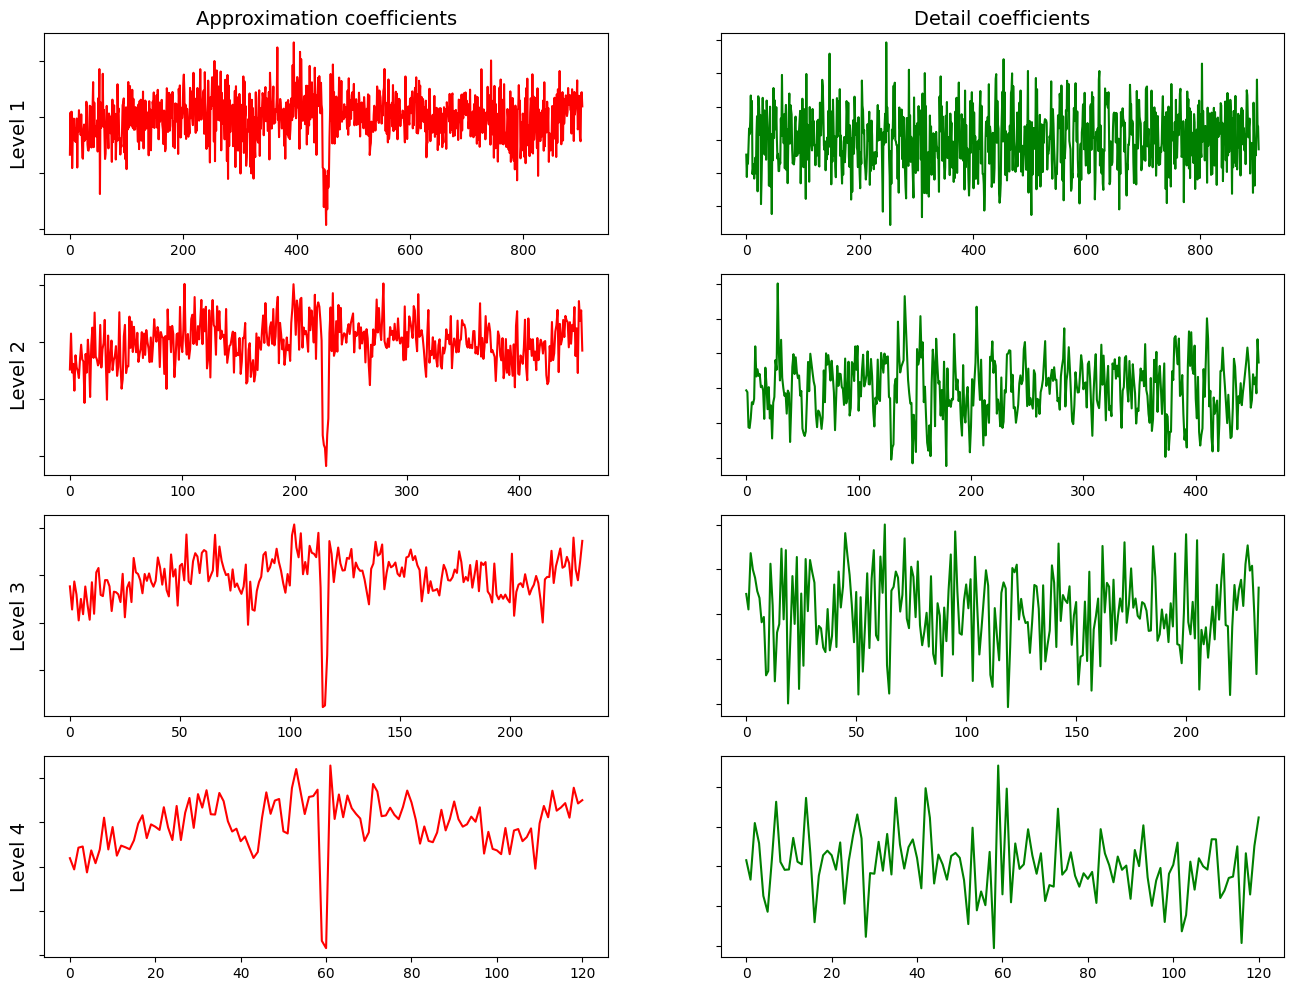

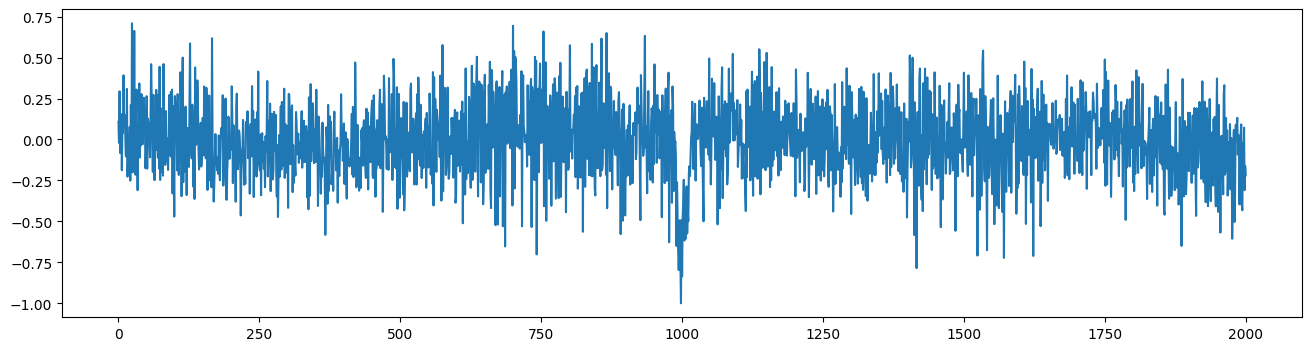

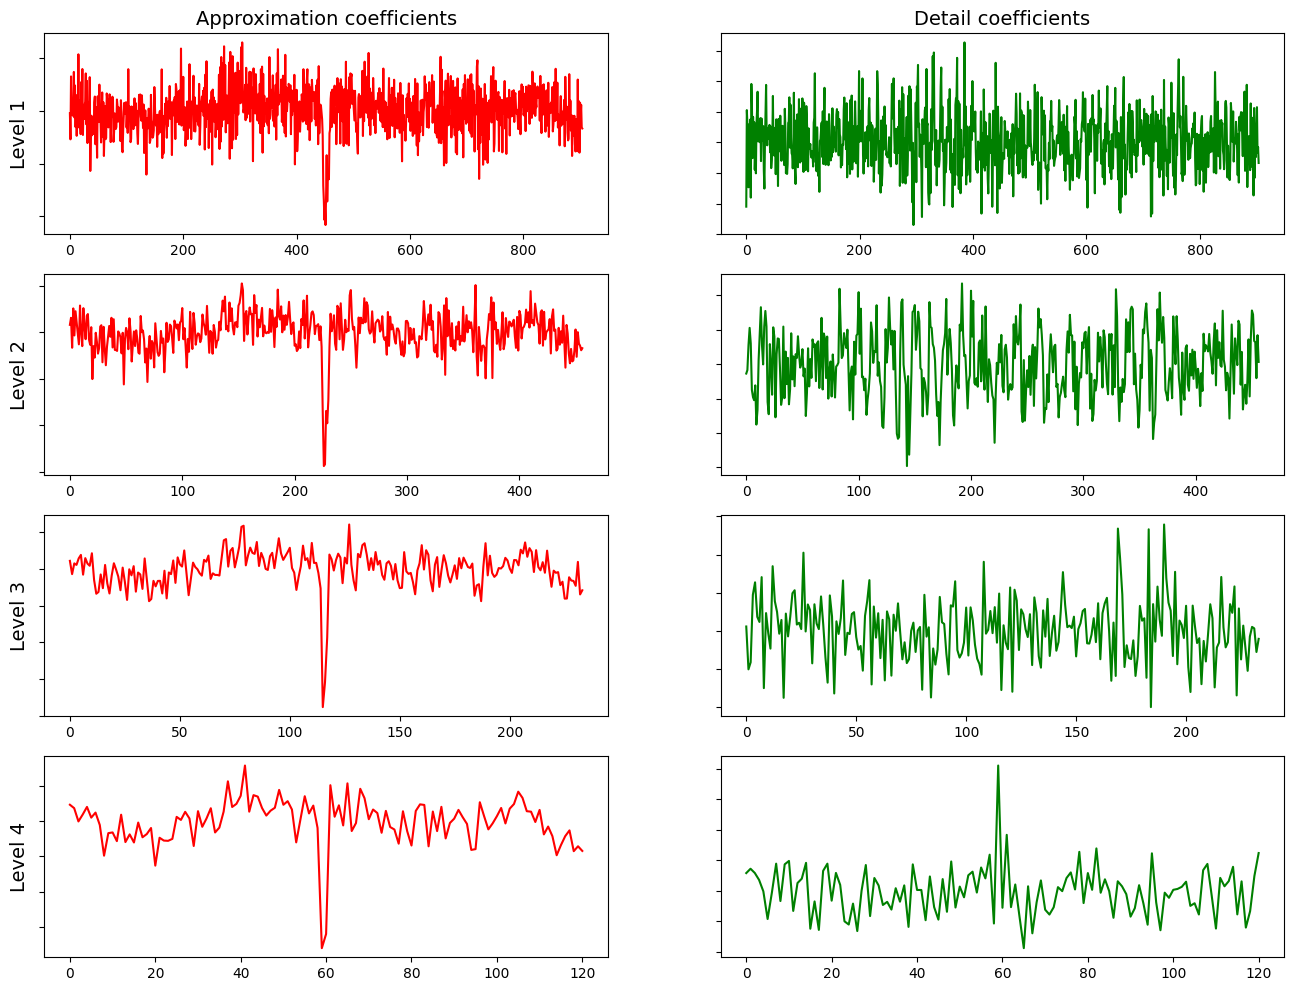

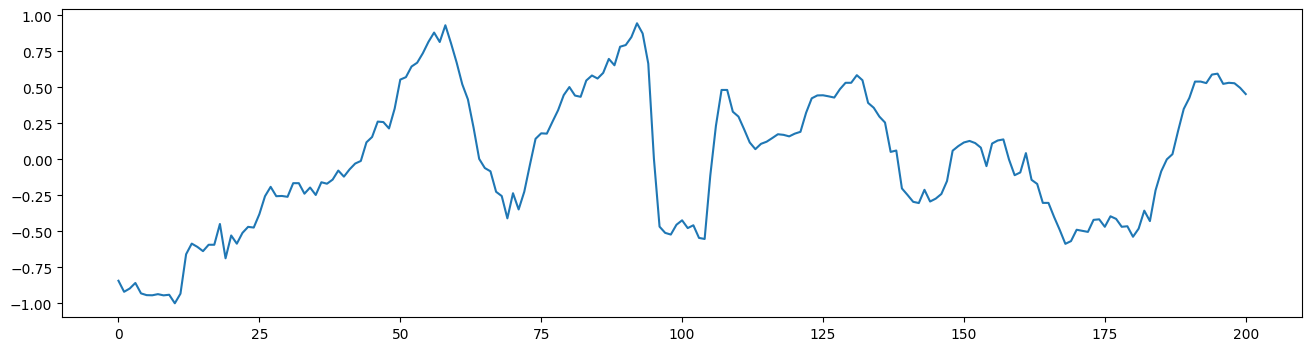

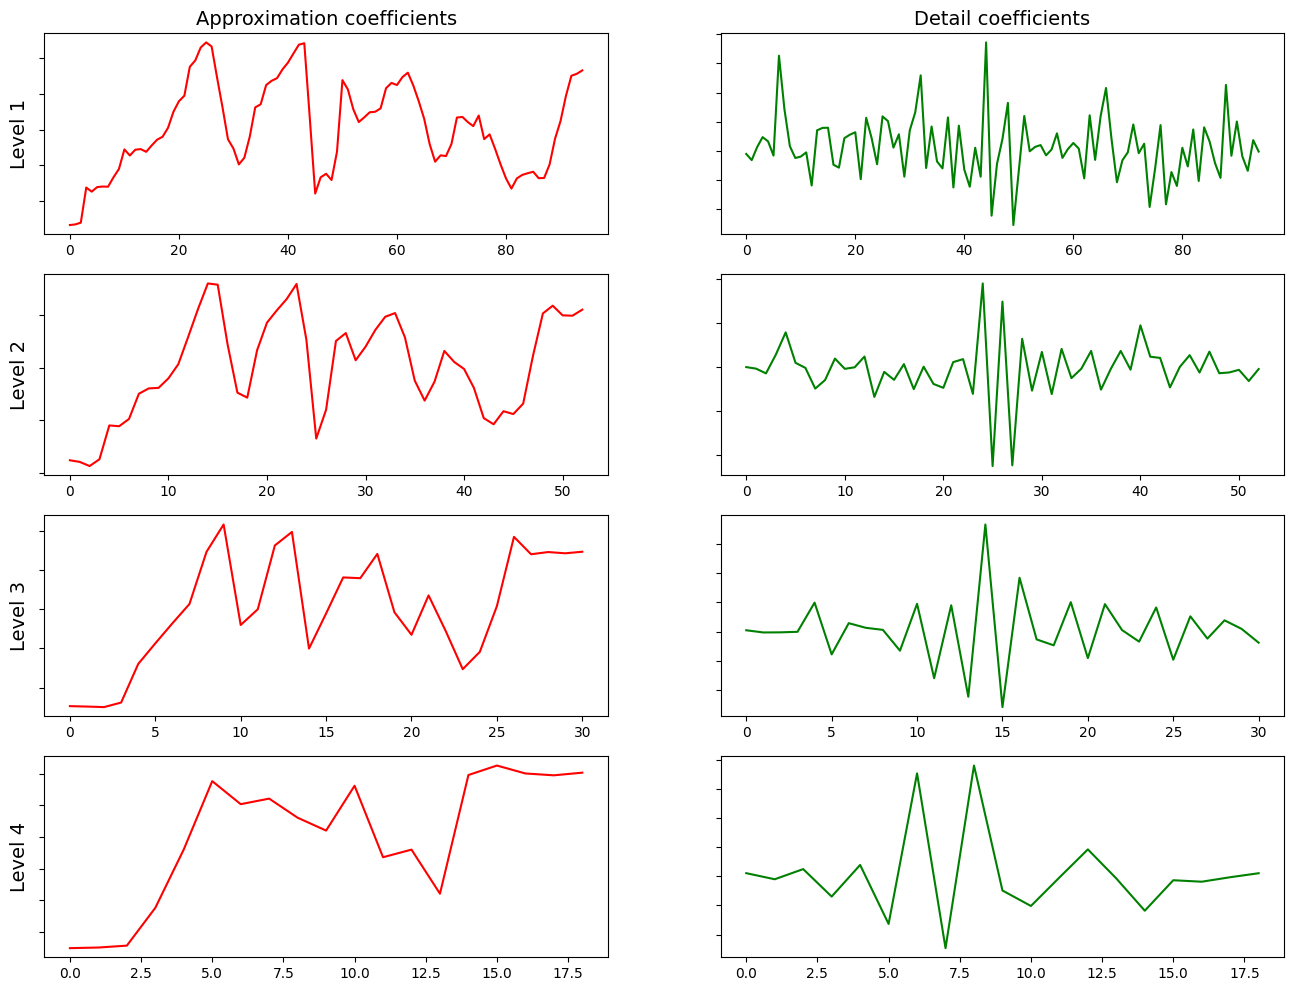

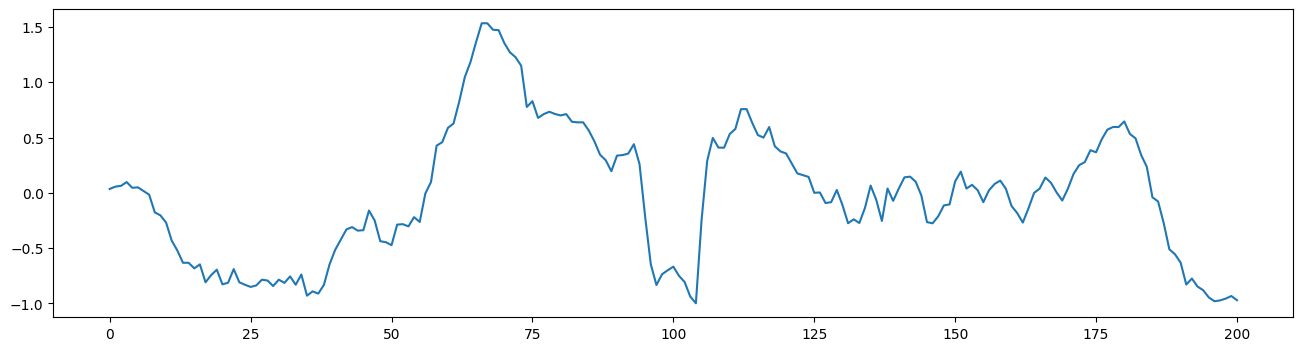

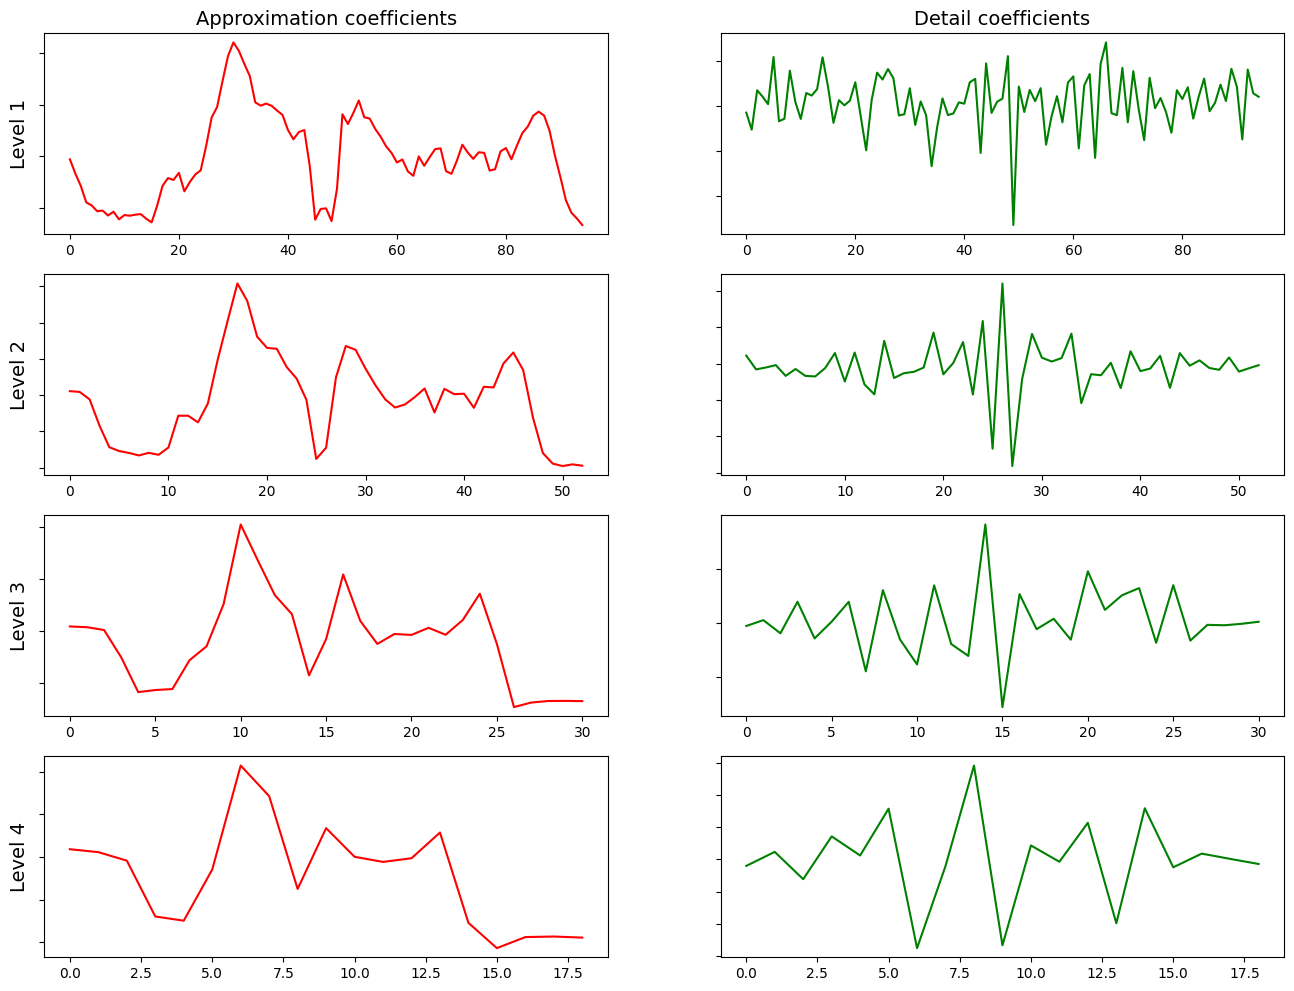

In [22]:


lc_w_even_global = LCWavelet.apply_wavelet(lc_even_global, wavelet_family, levels, cut_border_percent=cut_border_percent)
lc_w_odd_global = LCWavelet.apply_wavelet(lc_odd_global, wavelet_family, levels, cut_border_percent=cut_border_percent)

lc_w_even_local = LCWavelet.apply_wavelet(lc_even_local, wavelet_family, levels, cut_border_percent=cut_border_percent)
lc_w_odd_local = LCWavelet.apply_wavelet(lc_odd_local, wavelet_family, levels, cut_border_percent=cut_border_percent)

w_coll = LCWavelet.LightCurveWaveletGlobalLocalCollection(row.kepid, headers, lc_w_even_global, lc_w_odd_global, lc_w_even_local, lc_w_odd_local, levels)
w_coll.plot()
plt.show()

In [12]:
w_coll.save(r'.')


In [13]:
serie_path = r'E:\Diego\Astrofisica\TFM\ExoPlanet-Detection\test\kic_10797460-K00752_01.pickle'

# Check if the file exists and is not empty
w_lc = LCWavelet.LightCurveWaveletGlobalLocalCollection.from_pickle(serie_path)

w_lc

Note: you may need to restart the kernel to use updated packages.


El sistema no puede encontrar el archivo especificado.
